# ML Explainability
Adaptado del curso de Kaggle "Machine Learning Explainability"

## Instalaciones

In [66]:
!pip install eli5
!pip install pdpbox
!pip install shap

In [67]:
!pip install matplotlib==2.2.5

In [68]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Permutation Feature Importance

## Intro

Usaremos una muestra del dataset de la competencia "New York City Taxi Fare Prediction", la cuál tenia como objetivo predecir la tarifa de un viaje en taxi en la ciudad de Nueva York.

Para ello entrenaremos un modelo de RandomForest para poder evaluar la importancia de sus variables mediante PFI.

In [69]:
# Cargando data, spliteando y entrenando el modelo
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

data = pd.read_csv(main_dir+'data/new-york-city-taxi-fare-prediction/train.csv', nrows=50000)

# Removiendo data con puntos cardinales muy extremos o tarifas negativas
data = data.query('pickup_latitude > 40.7 and pickup_latitude < 40.8 and ' +
                  'dropoff_latitude > 40.7 and dropoff_latitude < 40.8 and ' +
                  'pickup_longitude > -74 and pickup_longitude < -73.9 and ' +
                  'dropoff_longitude > -74 and dropoff_longitude < -73.9 and ' +
                  'fare_amount > 0'
                  )

y = data.fare_amount

# Nos centraremos en estos features
base_features = ['pickup_longitude',
                 'pickup_latitude',
                 'dropoff_longitude',
                 'dropoff_latitude',
                 'passenger_count']

X = data[base_features]


train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
first_model = RandomForestRegressor(n_estimators=50, random_state=1).fit(train_X, train_y)


# Verificar
print("Data sample:")
data.head()

Data sample:


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1
6,2012-11-20 20:35:00.0000001,7.5,2012-11-20 20:35:00 UTC,-73.980002,40.751662,-73.973802,40.764842,1
7,2012-01-04 17:22:00.00000081,16.5,2012-01-04 17:22:00 UTC,-73.951300,40.774138,-73.990095,40.751048,1


The following two cells may also be useful to understand the values in the training data:

In [0]:
train_X.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,23466.000000,23466.000000,23466.000000,23466.000000,23466.000000
mean,-73.976827,40.756931,-73.975359,40.757434,1.662320
std,0.014625,0.018206,0.015930,0.018659,1.290729
min,-73.999999,40.700013,-73.999999,40.700020,0.000000
25%,-73.987964,40.744901,-73.987143,40.745756,1.000000
50%,-73.979629,40.758076,-73.978588,40.758542,1.000000
75%,-73.967797,40.769602,-73.966459,40.770406,2.000000
max,-73.900062,40.799952,-73.900062,40.799999,6.000000


In [0]:
train_y.describe()

count    23466.000000
mean         8.472539
std          4.609747
min          0.010000
25%          5.500000
50%          7.500000
75%         10.100000
max        165.000000
Name: fare_amount, dtype: float64

## Suposiciones
¿Qué variables van a ser útiles para predecir las tarifas de los taxis? ¿La tarifa dependerá del número de personas en el taxi? ¿De la zona de recojo/llegada?

## Aplicando Permutacion Feature Importance

Creamos un objeto `PermutationImportance` llamado `perm` para mostrar la importancia de variables de nuestro `first_model`.  Lo aplicaremos a nuestro dataset de validación.

In [70]:
import eli5
from eli5.sklearn import PermutationImportance

# Creando el objeto
perm = PermutationImportance(first_model, random_state=1).fit(val_X, val_y)

#q_2.check()

# Revisando los pesos asociados
eli5.show_weights(perm, feature_names = val_X.columns.tolist())

Weight,Feature
0.8387 ± 0.0168,dropoff_latitude
0.8326 ± 0.0212,pickup_latitude
0.5947 ± 0.0432,pickup_longitude
0.5326 ± 0.0275,dropoff_longitude
-0.0022 ± 0.0014,passenger_count


## Observaciones
¡Las variables relacionadas a la latitud tienen una mayor importancia!
De ello se pueden formular algunas hipótesis:
1. Los viajes pueden tener un mayor desplazamiento en latitud (norte/sur) que en longitud (este/oeste).
2. Diferentes partes de la ciudad pueden tener distintas reglas de pricing, las cuales varían más por latitud que longitud.
3. Puede existir un mayor número de peajes en las rutas de Norte<->Sur (cambiando latitud) a las rutas Este <-> Oeste (cambiando longitud).  Por ello la latitud tendría un mayor efecto en la predicción ya que captura la cantidad de peajes.

## Generando nuevas variables

Una buena idea sería crear nuevas variables sobre la distancia recorrida por el taxi.  

Aquí construimos estas nuevas variables, para longitud y latitud, y entrenamos un nuevo modelo

In [71]:
# Nuevas variables
data['abs_lon_change'] = abs(data.dropoff_longitude - data.pickup_longitude)
data['abs_lat_change'] = abs(data.dropoff_latitude - data.pickup_latitude)

features_2  = ['pickup_longitude',
               'pickup_latitude',
               'dropoff_longitude',
               'dropoff_latitude',
               'abs_lat_change',
               'abs_lon_change']

X = data[features_2]
new_train_X, new_val_X, new_train_y, new_val_y = train_test_split(X, y, random_state=1)
second_model = RandomForestRegressor(n_estimators=30, random_state=1).fit(new_train_X, new_train_y)

# Nuevo objeto PermutationImportance en el second_model y aplicado al nuevo dataset de validación
perm2 = PermutationImportance(second_model, random_state=1).fit(new_val_X, new_val_y)

# Mostrando los nuevos pesos
eli5.show_weights(perm2, feature_names = new_val_X.columns.tolist())


Weight,Feature
0.5786 ± 0.0294,abs_lat_change
0.4469 ± 0.0509,abs_lon_change
0.0860 ± 0.0334,pickup_latitude
0.0735 ± 0.0114,dropoff_latitude
0.0735 ± 0.0101,dropoff_longitude
0.0609 ± 0.0067,pickup_longitude


# Partial plots

## Creando PDPs para todos los features del primer modelo

Aquí graficamos los PDPs de todos los features, y analizamos sus efectos marginales.

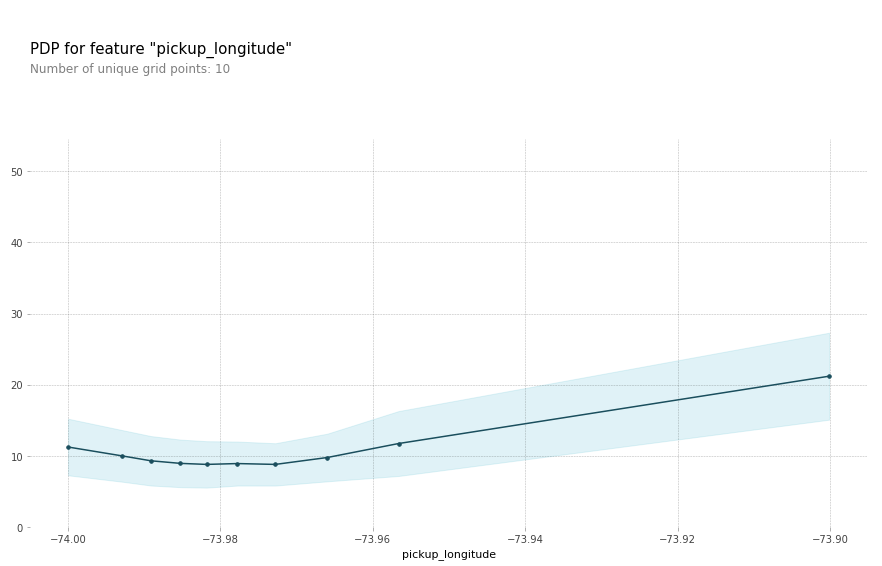

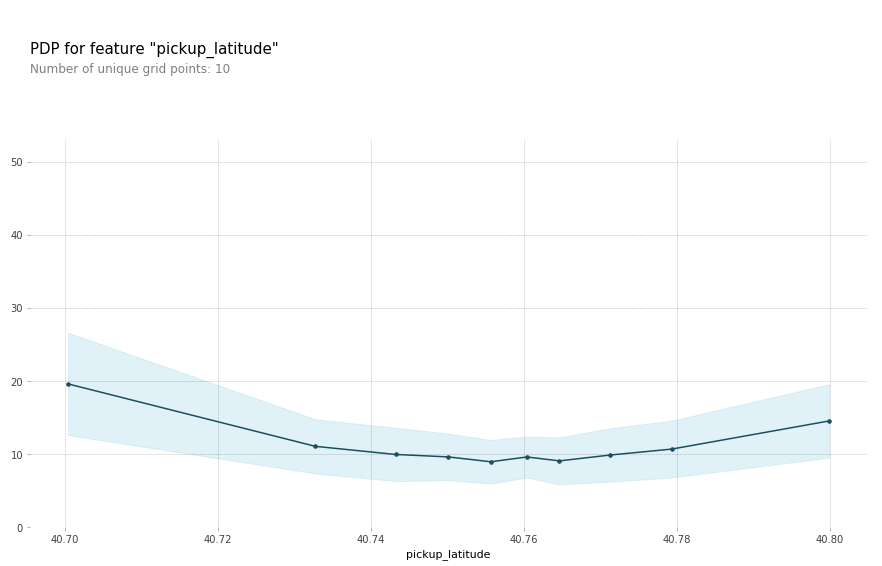

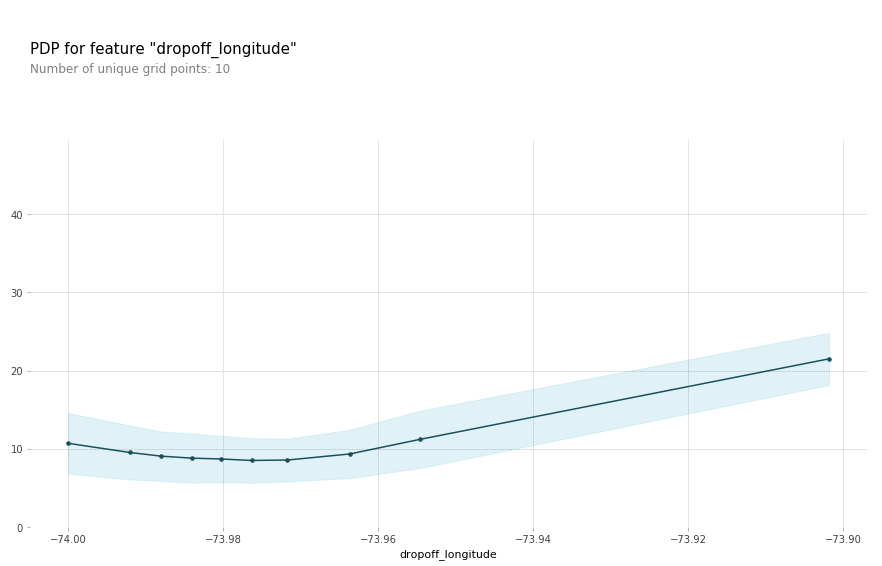

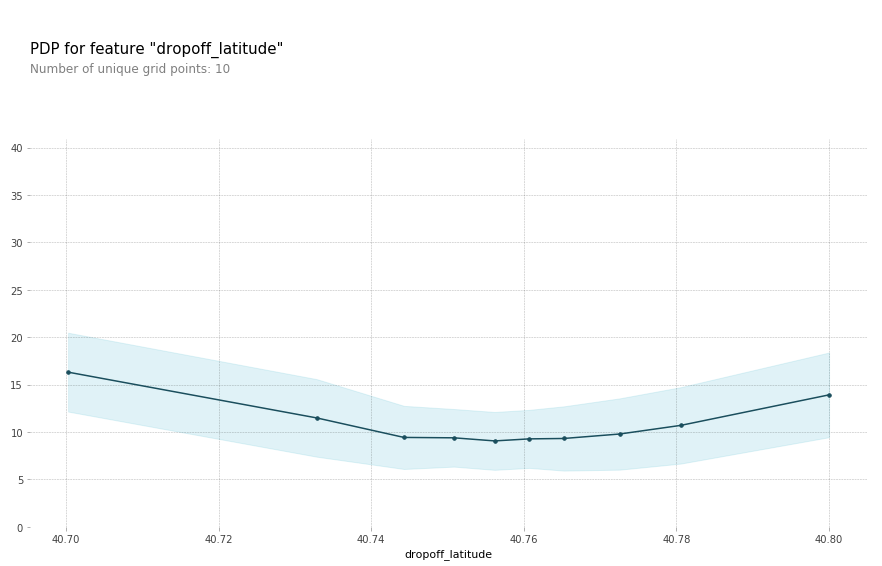

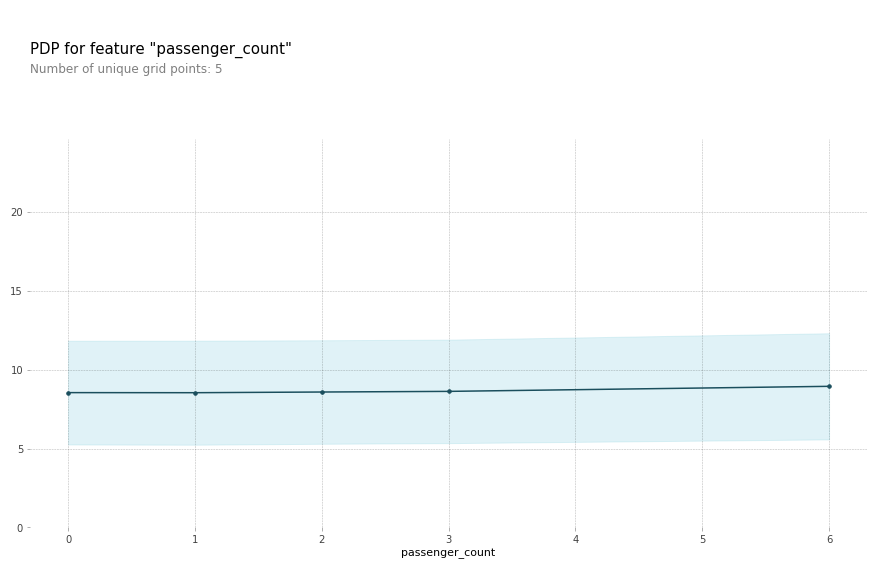

In [72]:
for feat_name in base_features:
    pdp_dist = pdp.pdp_isolate(model=first_model, dataset=val_X, model_features=base_features, feature=feat_name)
    pdp.pdp_plot(pdp_dist, feat_name, center=False)
    plt.show()

Como el primer modelo no incluye variables de distancia, las variables de coordenadas capturan este efecto.

Se recogido cerca del centro de longitud tiene un valores más bajos en promedio, porque significa que ls viajes son más cortos. Lo mismo ocurre con la latitud, por ello se pueden ver los plots en forma de U.

## Ploteando un pdp de 2 variables
Seguiremos usando el primer modelo para obtener insights de los features de posición.

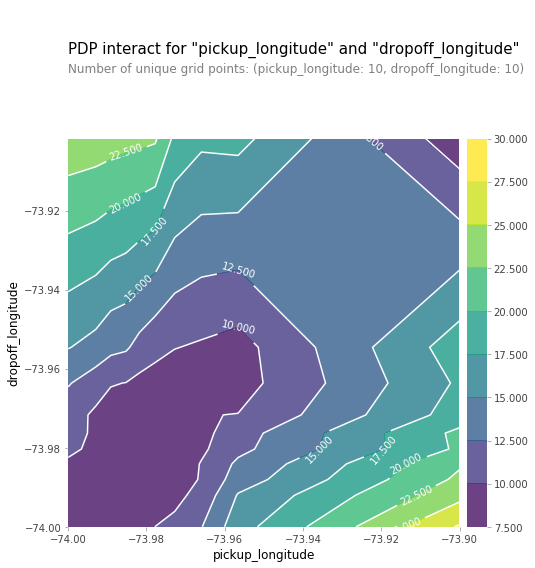

In [73]:
inter1  =  pdp.pdp_interact(model=first_model, dataset=val_X, model_features=base_features, features=['pickup_longitude', 'dropoff_longitude'])

pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=['pickup_longitude', 'dropoff_longitude'], plot_type='contour')
plt.show()

## Insights
Ver esos contornos en la diagonal es de esperarse. La diagonal para este plot de variables de longitud, estaría denotando que el viaje en el taxi ha sido entre puntos cercanos, es decir, viajes cortos, por lo que se puede ver que efectivamente tiene las predicciones más bajas. Lo contrario ocurre con la diagonal opuesta (de la esquina izquierda superior a la derecha inferior) ya que estamos hablando de los viajes más largos.

Un insight importante podría notarse en cómo mientras se acerca a la esquina superior derecha en la diagonal de identidad, los precios van incrementando. Esto merecería la pena investigarse un poco más a fondo.


# SHAP y usos avanzados

## Set Up

Para este siguiente caso cambiaremos de dataset, usaremos las técnicas previas, y haremos uso de los Shapley values para poder explicar las decisiones de nuestro modelo.




## El dataset y el problema

Un hospital tiene problemas con las readmisiones, que ocurren cuando un paciente es dado de alta antes de que se haya recuperado lo suficiente, provocando que vuelva al hospital con complicaciones de salud.

El hospital necesita identificar a aquellos pacientes que tienen una mayor probabilidad de ser readmitidos. Los doctores tomarán la decisión final sobre si dan de alta a un paciente o no, pero esperan que el modelo permita dar luz a aquellos puntos a considerar por los doctores dan la alta.

El dataset tiene información relevante de los pacientes:

In [0]:
import pandas as pd
data = pd.read_csv(main_dir+'data/hospital-readmissions/train.csv')
data.columns

Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses', 'race_Caucasian',
       'race_AfricanAmerican', 'gender_Female', 'age_[70-80)', 'age_[60-70)',
       'age_[50-60)', 'age_[80-90)', 'age_[40-50)', 'payer_code_?',
       'payer_code_MC', 'payer_code_HM', 'payer_code_SP', 'payer_code_BC',
       'medical_specialty_?', 'medical_specialty_InternalMedicine',
       'medical_specialty_Emergency/Trauma',
       'medical_specialty_Family/GeneralPractice',
       'medical_specialty_Cardiology', 'diag_1_428', 'diag_1_414',
       'diag_1_786', 'diag_2_276', 'diag_2_428', 'diag_2_250', 'diag_2_427',
       'diag_3_250', 'diag_3_401', 'diag_3_276', 'diag_3_428',
       'max_glu_serum_None', 'A1Cresult_None', 'metformin_No',
       'repaglinide_No', 'nateglinide_No', 'chlorpropamide_No',
       'glimepiride_No', 'acetohexamide_No', 'glipizide_No', 'glyburide_No',
     

Y aquí el significado de alguno de los campos:

- El target es la columna `readmitted`
- Las columnas con la palabra `diag` indican el código del diagnóstico por enfermedad o enfermedades con las que el paciente fue admitido.
- Las columnas con nombres como `glimepiride_No` indican que el paciente NO tome la medicina `glimepiride`. Si este feature tiene el valor de False, entonces significaría que dicho paciente sí tomó su medicina.
- Las variables con nombres `medical_specialty` describen la especialidad del doctor que vió al paciente. Tiene valores de True o False.


## Paso 1:

Los doctores no saben como evaluar un modelo simple que has construido, peri quieren validar que este modelo esté haciendo algo que esté alienado a su intuición médica.

Se contruye el modelo simple:

In [0]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split


data = pd.read_csv(main_dir+'data/hospital-readmissions/train.csv')

y = data.readmitted

base_features = [c for c in data.columns if c != "readmitted"]

X = data[base_features]


train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
my_model = RandomForestClassifier(n_estimators=30, random_state=1).fit(train_X, train_y)


Y hallamos el PFI para que los doctores puedan tener más visibilidad de las decisiones del modelo.

In [0]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(my_model, random_state=1).fit(val_X, val_y)
eli5.show_weights(perm, feature_names = val_X.columns.tolist())

Weight,Feature
0.0451 ± 0.0068,number_inpatient
0.0087 ± 0.0046,number_emergency
0.0062 ± 0.0053,number_outpatient
0.0033 ± 0.0016,payer_code_MC
0.0020 ± 0.0016,diag_3_401
0.0016 ± 0.0031,medical_specialty_Emergency/Trauma
0.0014 ± 0.0024,A1Cresult_None
0.0014 ± 0.0021,medical_specialty_Family/GeneralPractice
0.0013 ± 0.0010,diag_2_427
0.0013 ± 0.0011,diag_2_276


## Primeras observaciones

Se nota que el feature `number_inpatient` (número de procedimientos de hospitalización) es muy importante. Los doctores quieren más información de esta variable. Podemos crear un gráfico que permita ver como esta variable afecta las predicciones del modelo.


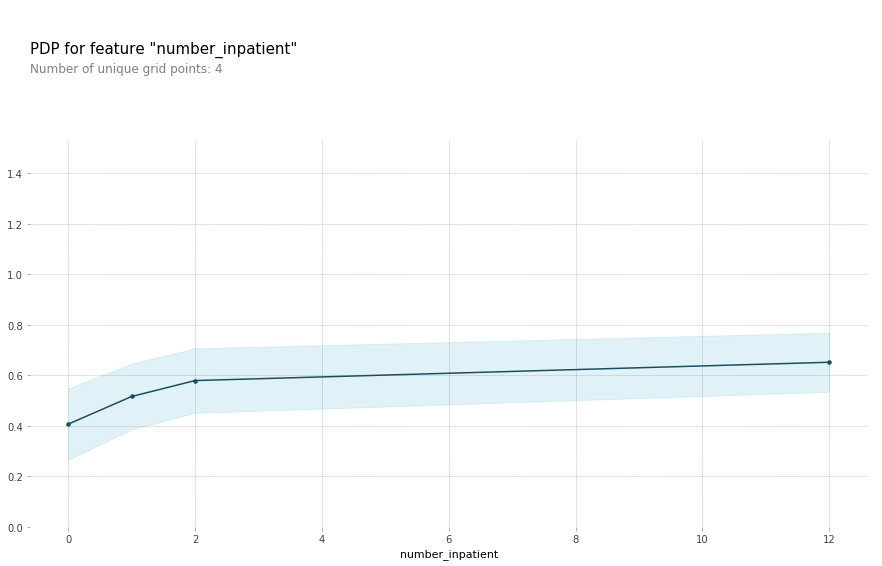

In [0]:
from matplotlib import pyplot as plt
from pdpbox import pdp, get_dataset, info_plots

feature_name = 'number_inpatient'

my_pdp = pdp.pdp_isolate(model=my_model, dataset=val_X, model_features=val_X.columns, feature=feature_name)

# plot
pdp.pdp_plot(my_pdp, feature_name, center=False)
plt.show()


## Feedback de los doctores

Los doctores creen que es una buena señar que a un mayor de procedimientos de hospitalización haya una mayor probabilidad de readmisión. Pero no tienen cómo visualizar si este cambio en el plot es grande o pequeño, y sugieren que se haga lo mismo para la variable de tiempo dentro del hospital.

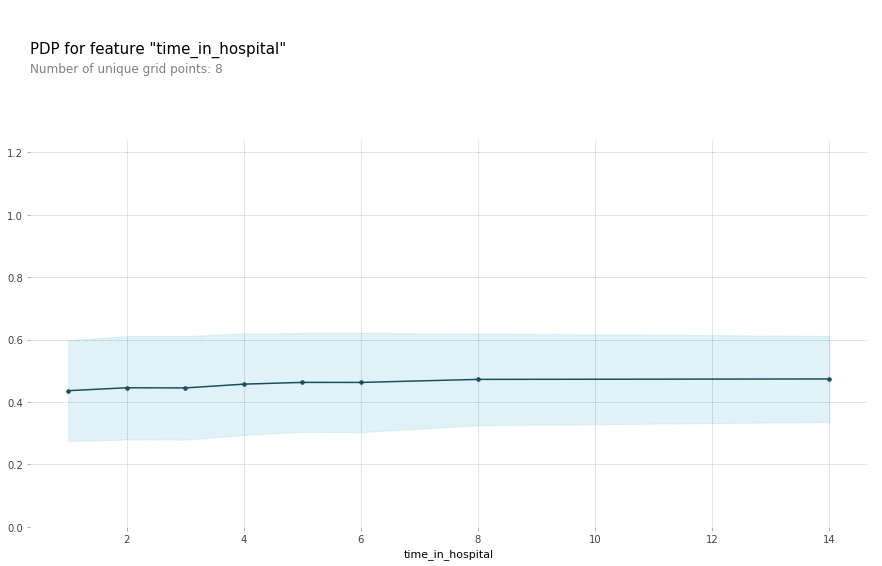

In [0]:
from matplotlib import pyplot as plt
from pdpbox import pdp, get_dataset, info_plots

feature_name = 'time_in_hospital'
# Crear la data a plotear
my_pdp = pdp.pdp_isolate(model=my_model, dataset=val_X, model_features=val_X.columns, feature=feature_name)

# plot
pdp.pdp_plot(my_pdp, feature_name, center=False)
plt.show()

Se puede observar que el tiempo en el hospital tiene un efecto mucho menor que el número de procedimientos de hospitalización. La diferencia entre el menor valor y el mayor valor es de aproximadamente 5%.


## Explicaciones individuales

Ahora que los doctores están convencidos de los análisis realizados, el requerimiento de los doctores es el siguiente: tomar data de una fila (de un único paciente) y crear una visualización mostrando las variables que **incrementan** el riesgo de readmisión, así como las variables que **disminuyen** este riesgo. No es necesario mostrar todas las variables, sino aquellas que causan un mayor impacto en la probabilidad final.

In [0]:
# Usando valores SHAP para mostrar el efecto de cada variable en la probabilidad de cada paciente.

import shap

def patient_risk_factors(model, patient_data):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(patient_data)
    shap.initjs()
    return shap.force_plot(explainer.expected_value[1], shap_values[1], patient_data)

In [0]:

sample_data_for_prediction = val_X.iloc[0].astype(float)  # primer paciente de el dataset de validación

In [0]:
patient_risk_factors(my_model,sample_data_for_prediction)

## Análisis más avanzados de SHAP
Volveremos a entrenar el modelo, con un menor número de variables y obteniendo un dataset de validación más pequeño, sobre el cuál utilizaremos SHAP para obtener insights del modelo usado y sus decisiones.

In [0]:
base_features = ['number_inpatient', 'num_medications', 'number_diagnoses', 'num_lab_procedures', 
                 'num_procedures', 'time_in_hospital', 'number_outpatient', 'number_emergency', 
                 'gender_Female', 'payer_code_?', 'medical_specialty_?', 'diag_1_428', 'diag_1_414', 
                 'diabetesMed_Yes', 'A1Cresult_None']

# Para evitar errores en la librería de shap pasamos booleanos a números
X = data[base_features].astype(float)

train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)

# Para una ejecución más rápida tomaremos un dataset de validación más pequeño
small_val_X = val_X.iloc[:150]
my_model = RandomForestClassifier(n_estimators=30, random_state=1).fit(train_X, train_y)

In [0]:
data.describe()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,readmitted
count,25000.000000,25000.00000,25000.000000,25000.000000,25000.000000,25000.000000,25000.00000,25000.000000,25000.000000
mean,4.395640,42.96012,1.341080,15.988440,0.365920,0.203280,0.64300,7.420160,0.456400
std,2.991165,19.76881,1.705398,8.107743,1.224419,0.982973,1.26286,1.940932,0.498105
min,1.000000,1.00000,0.000000,1.000000,0.000000,0.000000,0.00000,1.000000,0.000000
25%,2.000000,31.00000,0.000000,10.000000,0.000000,0.000000,0.00000,6.000000,0.000000
50%,4.000000,44.00000,1.000000,15.000000,0.000000,0.000000,0.00000,8.000000,0.000000
75%,6.000000,57.00000,2.000000,20.000000,0.000000,0.000000,1.00000,9.000000,1.000000
max,14.000000,126.00000,6.000000,81.000000,36.000000,64.000000,21.00000,16.000000,1.000000


Un primer análisis que podríamos hacer sería examinar la distribución de efectos para cada variable, más allá de sólo ver el efecto promedio para cada una. Para ello podemos hacer un SHAP summary plot, que combina la importancia de las variables junto con los efectos de la variable.

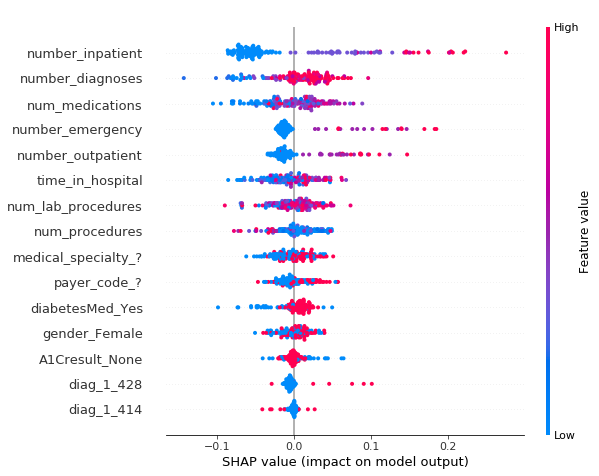

In [0]:
explainer = shap.TreeExplainer(my_model)
shap_values = explainer.shap_values(small_val_X, check_additivity=False)

shap.summary_plot(shap_values[1], small_val_X)

## Algunos insights que podemos observar

- El rango de efectos s e determina por el ancho que ocupan los puntos para una variable, mientras que la importancia del feature mantiene el ranking que muestra el plot. Así, la variable `diag_1_428` tiene un rango de efectos más frante que `payer_code_?`.

- Por ello, cambiar de 0 a 1 la variable `diag_1_428` tendría un mayor impacto en la predicción que cambiar de 0 a 1 la variable `payer_code_?`.

- Variables que tienen una mezcla de puntos azules y rosados sobrepuestos, indican que a veces estas variables pueden contribuit a dar una alta probabilidad, y a veces hacer lo contrario. Este es el caso de `num_lab_procedures`. La explicación para esto puede indicar que existe una interacción entre esta variable y otra que presente la misma distribución de SHAP values.




## Analizando interacciones




Podemos observar que **num_medications** and **num_lab_procedures** tienen una sobreposición de puntos rosados y azules.

Para ello construiremos SHAP dependence plots para cada variable, y analizaremos como estas dos variables afectan a las predicciones.
    
Analizaremos ello en nuestro reducido dataset de validación `small_val_X`.

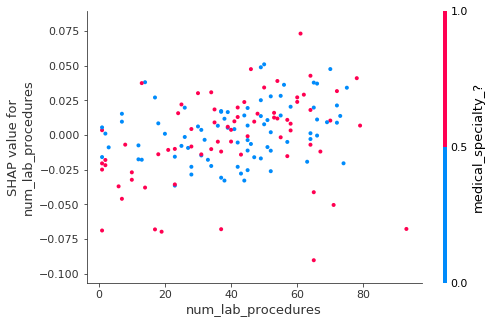

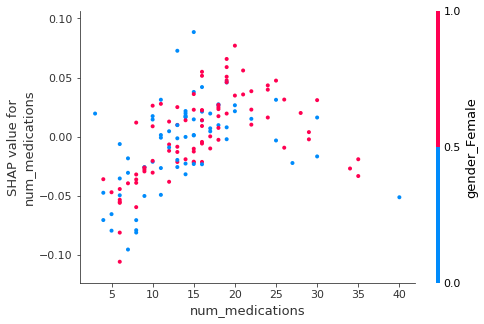

In [0]:
shap.dependence_plot('num_lab_procedures', shap_values[1], small_val_X)
shap.dependence_plot('num_medications', shap_values[1], small_val_X)

En términos generales, num_lab_procedures parece una nube con un pequeño patrón. No se inclina hacia arriba ni hacia abajo en ningún punto. Es difícil decir que hemos aprendido mucho de ese plot. Al mismo tiempo, los valores no están todos muy cerca de 0. Así que el modelo parece pensar que esta es una característica relevante. Un posible próximo paso sería explorar más juntandolo con otras variables diferentes para buscar una interacción.


Por otro lado, num_medications claramente se inclinan hacia arriba hasta un valor de alrededor de 20, y luego vuelven a bajar. Sin más antecedentes médicos, esto parece un fenómeno sorprendente... Se podría hacer una exploración para ver si estos pacientes tienen valores inusuales para otras variables también. Pero un buen paso siguiente sería discutir este fenómeno con expertos en el tema (en este caso, los médicos).